# Описание проекта

<span style="color:blue">
    
Компания <b>«Чётенькое такси»</b> собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики <b>RMSE</b> на тестовой выборке должно быть <b>не больше 48</b>.

<span>


## Содержание проекта  <a class="anchor" id="0-bullet">
* [Шаг 1. Анализ данных](#1-bullet)
* [Шаг 2. Подготовка данных](#2-bullet)    
* [Шаг 3. Обучение моделей и выбор лучшей модели](#3-bullet)

In [1]:
# Импортируем библиотеки, необходимые для выполнения проекта

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor, cv

from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Анализ данных<a class="anchor" id="1-bullet"></a>
👈[назад к оглавлению](#0-bullet)

In [2]:
datasets_path = ''
datasets_path = 'C:/Users/Venik/documents/Time_series'

In [3]:
taxi_data = pd.read_csv(datasets_path + '/datasets/taxi.csv')
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
# Сразу при импорте установим в качестве индекса временной промежуток
taxi_data = pd.read_csv(datasets_path + '/datasets/taxi.csv', parse_dates=[0], index_col = 'datetime')
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### <span style="color:green">План анализа данных<span>

<span style="color:blue">
    
1. Упорядочим временной ряд при необходимости.
2. Т.к. прогнозирование необходимо делать с точностью до часа, ресемплируем данные по часам. Т.к. целевой признак это информация по количеству заказов, в качестве агрегирующей функции возьмем сумму.
3. Проанализируем тренд временного ряда. Сезонность мы проанализировать не можем, т.к. данные у нас всего за полгода. Для этого укрупним данные по дням.
4. Проверим наш временной ряд на стационарность. Для этого выведем скользящее среднее для медианы и отклонения.
<span>

In [5]:
# Упорядочим временной ряд
if not taxi_data.index.is_monotonic:
    taxi_data.sort_index(inplace = True)

In [6]:
taxi_data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


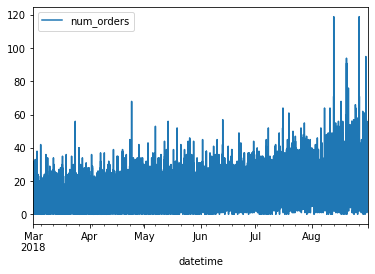

In [7]:
taxi_data.plot()

In [8]:
# Ресемплируем ряд до часовыx промежутков.
taxi_data = taxi_data.resample('1H').sum()
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [9]:
taxi_data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


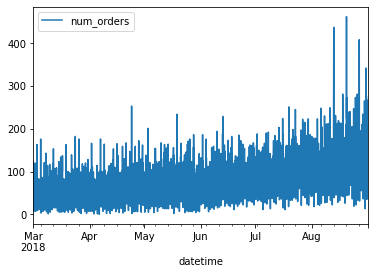

In [10]:
taxi_data.plot()

In [11]:
# Построим график тренда временного ряда.
taxi_data_daily = taxi_data.resample('1D').sum()
decomposed_taxi_data = seasonal_decompose(taxi_data_daily)

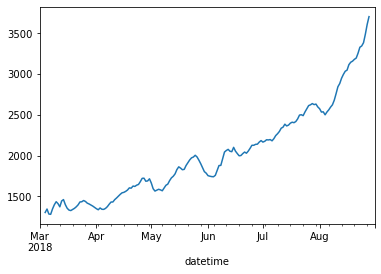

In [12]:
decomposed_taxi_data.trend.plot()

<span style="color:blue">
Во временном ряде мы видим четкий восходящий тренд. Количество заказов в службе увеличивается из месяца в месяц.
<span>

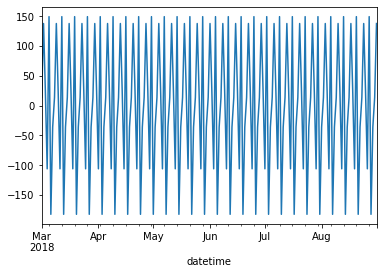

In [13]:
decomposed_taxi_data.seasonal.plot()

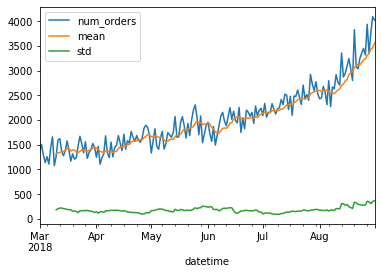

In [14]:
# Проанализируем временной ряд на стационарность
taxi_data_daily['mean'] = taxi_data_daily['num_orders'].rolling(10).mean()
taxi_data_daily['std'] = taxi_data_daily['num_orders'].rolling(10).std()
taxi_data_daily.plot()

<span style="color:blue">
Временной ряд не стационарный, т.к. среднее у него постоянно увеличивается. Однако стандартное отклонение у него достаточно стабильно, т.е этот ряд возможно прогнозировать.

<b>Приступим к подготовке данных для обучения.</b>
<span>

# 2. Подготовка данных<a class="anchor" id="2-bullet"></a>
👈[назад к оглавлению](#0-bullet)

### <span style="color:green">План подготовки данных<span>

<span style="color:blue">
    
1. Добавим календарные признаки. Год нам для текущего прогноза не нужен, т.к. все данные находятся в рамках одного года, а вот месяц, день месяца и день недели нужны.
2. Добавим отстающие значения. Для того, чтобы можно было в дальнейшем менять их количество, напишем функцию, преобразующую данные в зависимости от передаваемого в нее значения количества отстающих значений. Для начала возьмем значение 5.
3. Добавим признак "скользящее среднее". Его мы также будем варьировать функцией, исходя из размера окна. Для начала возьмем размер окна равным 5.
4. Удалим строки с пропусками.
5. Подберем наилучшее сочетание количества отстающих значений и размера окна. Для вычисления лучшего RMSE на каждом из датасетов будем использовать линейную регрессию.
<span>

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [16]:
taxi_data_for_train = taxi_data.copy()
make_features(taxi_data_for_train, 5, 5)
taxi_data_for_train.dropna(inplace = True)
taxi_data_for_train.head(10)

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,
2018-03-01 05:00:00,6,3,1,3,43.0,66.0,71.0,85.0,124.0,77.8
2018-03-01 06:00:00,12,3,1,3,6.0,43.0,66.0,71.0,85.0,54.2
2018-03-01 07:00:00,15,3,1,3,12.0,6.0,43.0,66.0,71.0,39.6
2018-03-01 08:00:00,34,3,1,3,15.0,12.0,6.0,43.0,66.0,28.4
2018-03-01 09:00:00,69,3,1,3,34.0,15.0,12.0,6.0,43.0,22.0
2018-03-01 10:00:00,64,3,1,3,69.0,34.0,15.0,12.0,6.0,27.2
2018-03-01 11:00:00,96,3,1,3,64.0,69.0,34.0,15.0,12.0,38.8
2018-03-01 12:00:00,30,3,1,3,96.0,64.0,69.0,34.0,15.0,55.6
2018-03-01 13:00:00,32,3,1,3,30.0,96.0,64.0,69.0,34.0,58.6


In [17]:
def prepare_data(taxi_data, 
                max_lag,
                rolling_mean_size):

    taxi_data_for_train = taxi_data.copy()
            
    make_features(taxi_data_for_train, max_lag, rolling_mean_size)
    taxi_data_for_train.dropna(inplace = True)
    
    train_valid, test = train_test_split(taxi_data_for_train, shuffle=False, test_size=0.1)
    train, valid = train_test_split(train_valid, shuffle=False, test_size=0.25)

    train_features = train.drop(['num_orders'], axis = 1)
    valid_features = valid.drop(['num_orders'], axis = 1)
    test_features = test.drop(['num_orders'], axis = 1)

    train_target = train['num_orders']
    valid_target = valid['num_orders']
    test_target = test['num_orders']

    return (train_features, 
            valid_features, 
            test_features, 
            train_target, 
            valid_target, 
            test_target)

In [18]:
best_rmse = 100000
best_max_lag = 5
best_rolling_mean_size = 5

for current_max_lag in range(6, 25):
    for current_rolling_mean_size in range(6,25):
        
        train_features, valid_features, test_features, train_target, valid_target, test_target = prepare_data(taxi_data, 
                                                                                                    current_max_lag,
                                                                                                    current_rolling_mean_size)
        model = LinearRegression()
        model.fit(train_features, train_target)

        predictions = model.predict(valid_features)

        current_rmse = mean_squared_error(valid_target, predictions)**.5

        if best_rmse > current_rmse:
            best_rmse = current_rmse
            best_max_lag = current_max_lag
            best_rolling_mean_size = current_rolling_mean_size

print("Лучший RMSE:", best_rmse)
print("Лучшее количество разностей: ", best_max_lag)
print("Лучший размер окна: ", best_rolling_mean_size)

Лучший RMSE: 31.849149397699044
Лучшее количество разностей:  24
Лучший размер окна:  14


### <span style="color:green">Выводы по результатам подготовки данных<span>

Мы получили наилучшие параметры датасета для обучения модели по временному ряду.     

<span style="color:orange">
Лучшее количество разностей: 23.
Лучший размер окна:  24.
<span>

<span style="color:blue">Приступим к обучению различных моделей на этом датасете.<span>

# 3. Обучение моделей и выбор лучшей модели<a class="anchor" id="3-bullet"></a>
👈[назад к оглавлению](#0-bullet)

### <span style="color:green">План обучения моделей<span>

<span style="color:blue">

1. Разобъем данные на тренировочную и тестовую выборки в размере 9:1.
2. Обучим такие модели как Линейная регрессия, Решающее дерево, Случайный лес, LightGBM и CatBoost с различными гиперпараметрами.
3. Соберем все результаты обучения в единую таблицу и проведем анализ того, какая модель лучше справилась с здадачей.
<span>

In [19]:
# Создадим сравнительный датасет в который будем писать параметры модели
compare = {'model_name' : [],
           'param1_name' : [],
           'param1_value' : [],
           'param2_name' : [],
           'param2_value' : [],
           'rmse' : []
           }

compare_data_models = pd.DataFrame(compare)

In [20]:
# Функция для добавления строки в сравнительную таблицу
def add_model_params(model_name,
                     param1_name,
                     param1_value,
                     param2_name,
                     param2_value,
                     rmse,
                     compare_data):
    
    compare_data = compare_data.append(pd.DataFrame([[model_name, 
                                                      param1_name,
                                                      param1_value,
                                                      param2_name,
                                                      param2_value,
                                                      rmse]], 
                                                      columns = ['model_name', 
                                                                 'param1_name',
                                                                 'param1_value',
                                                                 'param2_name',
                                                                 'param2_value',
                                                                 'rmse']),
                                                      ignore_index=True)
    
    return compare_data

In [21]:
train_features, valid_features, test_features, train_target, valid_target, test_target = prepare_data(taxi_data, 
                                                                                                    best_max_lag,
                                                                                                    best_rolling_mean_size)


In [22]:
model = LinearRegression()

train_valid_features = pd.concat([train_features, valid_features])
train_valid_target = pd.concat([train_target, valid_target])

model.fit(train_valid_features, train_valid_target)

test_predictions = model.predict(test_features)

rmse = mean_squared_error(test_target, test_predictions)**.5

compare_data_models = add_model_params('LinearRegression', 
                                        'None', 
                                        0,
                                        'None',
                                        0,
                                         rmse,
                                        compare_data_models) 

compare_data_models

,model_name,param1_name,param1_value,param2_name,param2_value,rmse
0,LinearRegression,None,0.0,None,0.0,45.542447


In [23]:
# Дерево решений (подбор параметров)

best_rmse = 10000
best_depth = 0

for depth in range(1, 50):
    
    model = DecisionTreeRegressor(random_state=12345, max_depth = depth)
    model.fit(train_features, train_target)
    
    predictions = model.predict(valid_features)
    
    current_rmse = mean_squared_error(valid_target, predictions)**.5
    
    if best_rmse > current_rmse:
        best_rmse = current_rmse
        best_depth = depth

# Проверим RMSE на тестовой выборке
model = DecisionTreeRegressor(random_state=12345, max_depth = best_depth)

train_valid_features = pd.concat([train_features, valid_features])
train_valid_target = pd.concat([train_target, valid_target])

model.fit(train_valid_features, train_valid_target)

test_predictions = model.predict(test_features)    
rmse = mean_squared_error(test_target, test_predictions)**.5


compare_data_models = add_model_params('DecisionTreeRegressor', 
                                        'depth', 
                                        best_depth,
                                        'None',
                                        0,
                                        rmse,
                                        compare_data_models) 

compare_data_models

,model_name,param1_name,param1_value,param2_name,param2_value,rmse
0,LinearRegression,None,0.0,None,0.0,45.542447
1,DecisionTreeRegressor,depth,7.0,None,0.0,64.623126


In [24]:
# Случайный лес (подбор параметров)

best_rmse = 100000
best_max_depth = 0
best_n_estimators = 0

for m_depth in range(10, 100, 10):
    for n_estim in range(1, 30):
    
        model = RandomForestRegressor(random_state=12345, max_depth = m_depth, n_estimators=n_estim)
        model.fit(train_features, train_target)
    
        predictions = model.predict(valid_features)

        current_rmse = mean_squared_error(valid_target, predictions)**.5
    
        if best_rmse > current_rmse:
            best_rmse = current_rmse
            best_max_depth = m_depth
            best_n_estimators = n_estim

        
# Проверим RMSE на тестовой выборке
model = RandomForestRegressor(random_state=12345, max_depth = best_max_depth, n_estimators=best_n_estimators)

train_valid_features = pd.concat([train_features, valid_features])
train_valid_target = pd.concat([train_target, valid_target])

model.fit(train_valid_features, train_valid_target)

test_predictions = model.predict(test_features)
rmse = mean_squared_error(test_target, test_predictions)**.5
    
compare_data_models = add_model_params('RandomForestRegressor', 
                                        'max_depth',
                                        best_max_depth,
                                        'n_estimators', 
                                        best_n_estimators,
                                        rmse,
                                        compare_data_models) 

compare_data_models

,model_name,param1_name,param1_value,param2_name,param2_value,rmse
0,LinearRegression,None,0.0,None,0.0,45.542447
1,DecisionTreeRegressor,depth,7.0,None,0.0,64.623126
2,RandomForestRegressor,max_depth,20.0,n_estimators,27.0,43.901186


In [25]:
# Установим общие параметры для LightGBM и CatBoost
start_n_estimators = 150
finish_n_estimators = 200
step_n_estimators = 10

In [26]:
# Обучим LightGBM, выберем лучшие гиперпараметры, исходя из RMSE и добавим параметры в таблицу

# Введем переменную с заведомо большим RMSE и в таблицу запишем только те параметры, 
# по которым мы получим лучшее значение
best_rmse = 100000

best_max_depth = 0
best_n_estimators = 0

start_max_depth = 24
finish_max_depth = 27
step_max_depth = 2

# Подберем лучшие параметры
for current_max_depth in range(start_max_depth, 
                                finish_max_depth, 
                                step_max_depth):
    for current_n_estimators in range(start_n_estimators, 
                                        finish_n_estimators, 
                                        step_n_estimators):
                    
        model = LGBMRegressor(random_state=12345, 
                                max_depth = current_max_depth,
                                n_estimators = current_n_estimators)    
        
        model.fit(train_features, train_target)

        predictions = model.predict(valid_features)

        current_rmse = mean_squared_error(valid_target, predictions)**.5
    
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_n_estimators = current_n_estimators
            best_max_depth = current_max_depth

# Проверим RMSE на тестовой выборке
model = LGBMRegressor(random_state=12345, 
                      max_depth = best_max_depth,
                      n_estimators = best_n_estimators)    

train_valid_features = pd.concat([train_features, valid_features])
train_valid_target = pd.concat([train_target, valid_target])

model.fit(train_valid_features, train_valid_target)

test_predictions = model.predict(test_features)
rmse = mean_squared_error(test_target, test_predictions)**.5

compare_data_models = add_model_params('LGBMRegressor', 
                                        'max_depth', 
                                        best_max_depth,
                                        'n_estimators',
                                        best_n_estimators,
                                        rmse,
                                        compare_data_models) 

compare_data_models

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max

,model_name,param1_name,param1_value,param2_name,param2_value,rmse
0,LinearRegression,None,0.0,None,0.0,45.542447
1,DecisionTreeRegressor,depth,7.0,None,0.0,64.623126
2,RandomForestRegressor,max_depth,20.0,n_estimators,27.0,43.901186
3,LGBMRegressor,max_depth,24.0,n_estimators,150.0,41.887015


In [27]:
# Обучим CatBoost, выберем лучшие гиперпараметры, исходя из RMSE и добавим параметры в таблицу

# Введем переменную с заведомо большим RMSE и в таблицу запишем только те параметры, 
# по которым мы получим лучшее значение
best_rmse = 100000

best_depth = 0
best_n_estimators = 0

start_depth = 14
finish_depth = 17
step_depth = 2
    
for current_depth in range(start_depth, 
                            finish_depth, 
                            step_depth):
    for current_n_estimators in range(start_n_estimators, 
                                        finish_n_estimators, 
                                        step_n_estimators):

        params = {"n_estimators": current_n_estimators,
                  "depth": current_depth,
                  "loss_function": "RMSE",
                  #"verbose": False}
                  "verbose": 20}

        model = CatBoostRegressor(depth = current_depth,
                                  n_estimators = current_n_estimators,
                                  verbose = 50, loss_function = 'RMSE')    

        train_pool = Pool(train_features, train_target)
                          
        model.fit(train_pool)

        predictions = model.predict(valid_features)

        current_rmse = mean_squared_error(valid_target, predictions)**.5
    
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_n_estimators = current_n_estimators
            best_depth = current_depth

model = CatBoostRegressor(depth = best_depth,
                            n_estimators = best_n_estimators,
                            verbose = 50, loss_function = 'RMSE')    

train_valid_features = pd.concat([train_features, valid_features])
train_valid_target = pd.concat([train_target, valid_target])

train_pool = Pool(train_valid_features, train_valid_target)

model.fit(train_pool)

test_predictions = model.predict(test_features)
rmse = mean_squared_error(test_target, test_predictions)**.5

compare_data_models = add_model_params('CatBoostRegressor', 
                                        'depth', 
                                        best_depth,
                                        'n_estimators',
                                        best_n_estimators,
                                        rmse,
                                        compare_data_models) 

compare_data_models

Learning rate set to 0.200247
0:	learn: 31.3295911	total: 1.01s	remaining: 2m 30s
50:	learn: 4.8068187	total: 43.6s	remaining: 1m 24s
100:	learn: 1.6503020	total: 1m 29s	remaining: 43.4s
149:	learn: 0.6152126	total: 2m 15s	remaining: 0us
Learning rate set to 0.190662
0:	learn: 31.4504672	total: 814ms	remaining: 2m 9s
50:	learn: 5.0924314	total: 43.7s	remaining: 1m 33s
100:	learn: 1.6243185	total: 1m 27s	remaining: 50.9s
150:	learn: 0.5833365	total: 2m 9s	remaining: 7.71s
159:	learn: 0.4879933	total: 2m 17s	remaining: 0us
Learning rate set to 0.182077
0:	learn: 31.5590968	total: 849ms	remaining: 2m 23s
50:	learn: 5.7915673	total: 43.5s	remaining: 1m 41s
100:	learn: 1.8512238	total: 1m 26s	remaining: 59.2s
150:	learn: 0.7479223	total: 2m 9s	remaining: 16.3s
169:	learn: 0.4996689	total: 2m 25s	remaining: 0us
Learning rate set to 0.174336
0:	learn: 31.6573396	total: 815ms	remaining: 2m 25s
50:	learn: 5.8368986	total: 43.6s	remaining: 1m 50s
100:	learn: 2.0349571	total: 1m 27s	remaining: 1m

,model_name,param1_name,param1_value,param2_name,param2_value,rmse
0,LinearRegression,None,0.0,None,0.0,45.542447
1,DecisionTreeRegressor,depth,7.0,None,0.0,64.623126
2,RandomForestRegressor,max_depth,20.0,n_estimators,27.0,43.901186
3,LGBMRegressor,max_depth,24.0,n_estimators,150.0,41.887015
4,CatBoostRegressor,depth,14.0,n_estimators,170.0,53.177449


## <span style="color:green">Выбор лучшей модели<span>

<span style="color:orange">
    
Лучше всех с задачей справилась такая модель, как <b>Линейная регрессия (RMSE = 46.93)</b>. Она единственная прошла необходимый порог.
    
<span>


## <span style="color:red">ВЫВОД<span>
    
<span style="color:red">Учитывая простоту использования и скорость работы простых моделей (таких, как <b>Линейная регрессия</b>), для прогнозирования количества заказов на следующий час необходимо использовать ее.<span>